In [1]:
import tensorflow as tf
# This should print out an output like "/device:GPU:0". If you get an empty 
# string, verify you are on a GPU runtime. 
# Goto Runtime menu -> Change runtime type -> Select GPU in the hardware accelerator spinner
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
#@title Default title text
import pandas as pd
import itertools
import tensorflow as tf
import os
import re
import numpy as np
from StringIO import StringIO
from tensorflow.contrib.layers.python.layers.initializers import xavier_initializer
from IPython.display import clear_output
from sklearn.metrics import classification_report,confusion_matrix
%pylab inline
matplotlib.pyplot.style.use = 'default'

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Fetching file meta data from Google Drive folder
file_list = drive.ListFile({'q': "'1K_8auEsRPCRd11cl7mRkipb66xlghbZi' in parents and trashed=false"}).GetList()
file_list = map(lambda x : (x['id'], x['title']), file_list)

In [6]:
uploaded = 0
for i,file_meta in enumerate(file_list):
  #clear_output()
  file = drive.CreateFile({'id': file_meta[0]})
  file.GetContentFile(file_meta[1])
  uploaded += 1
  print 'Creating file {} uploaded {}'.format(file_meta[1], uploaded)

Creating file table_te.csv uploaded 1
Creating file table_hrs.csv uploaded 2
Creating file table_cl.csv uploaded 3
Creating file table_schw.csv uploaded 4
Creating file table_nvda.csv uploaded 5
Creating file table_vz.csv uploaded 6
Creating file table_chrw.csv uploaded 7
Creating file table_dri.csv uploaded 8
Creating file table_biib.csv uploaded 9
Creating file table_bbby.csv uploaded 10
Creating file table_ivz.csv uploaded 11
Creating file table_sre.csv uploaded 12
Creating file table_pom.csv uploaded 13
Creating file table_pxd.csv uploaded 14
Creating file table_twx.csv uploaded 15
Creating file table_vmc.csv uploaded 16
Creating file table_vno.csv uploaded 17
Creating file table_apol.csv uploaded 18
Creating file table_ctxs.csv uploaded 19
Creating file table_trip.csv uploaded 20
Creating file table_mur.csv uploaded 21
Creating file table_mmc.csv uploaded 22
Creating file table_cof.csv uploaded 23
Creating file table_bf.b.csv uploaded 24
Creating file table_hst.csv uploaded 25
Cre

In [ ]:
ticker_regex = re.compile('.+_(?P<ticker>.+)\.csv')

#### Formula for Logarithmic Return: \begin{equation*}R = ln(\frac{V_f}{V_i})\end{equation*}
Source : https://en.wikipedia.org/wiki/Rate_of_return

In [ ]:
#helper functions
def get_ticker(path):
    return ticker_regex.match(path).groupdict()['ticker']

def log_ret(vi,vf):
    # Log return
    return np.log(vf/vi)

def zscore(x):
    return (x - x.mean())/x.std()

def prepare(file, data):
    """
    O - Open
    H - High
    L - Low
    C - Close
    V - Volume
    """
    df = pd.read_csv(data, header=None, names=['UNK', 'O', 'H', 'L', 'C', 'V'])
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    ticker = get_ticker(file)
    res = pd.DataFrame()
    
    res['C_2_O'] = zscore(log_ret(df.O, df.C))
    res['H_2_O'] = zscore(log_ret(df.O, df.H))
    res['L_2_O'] = zscore(log_ret(df.O, df.L))
    res['C_2_H'] = zscore(log_ret(df.H, df.C))
    res['L_2_H'] = zscore(log_ret(df.H, df.L))
    res['Ct_2_Ct1'] = log_ret(df.C, df.C.shift(-1)).fillna(0)
    res['Vol'] = zscore(df.V)
    res['Ticker'] = ticker
    
    return res

def label(x):
    if x > 0.0029:
        return 1
    if x < -0.00426:
        return -1
    return 0

def interpolate(series, method='time'):
    return series.interpolate(method=method)

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  #print(cm)
  plt.figure(figsize=(7,5))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
file_names = zip(*file_list)[1]
filepaths = dict(zip(file_names, file_names))

In [ ]:
k, v = filepaths.keys()[0], filepaths[filepaths.keys()[0]]

In [ ]:
res = prepare(k,v)

In [14]:
res.head()

,C_2_O,H_2_O,L_2_O,C_2_H,L_2_H,Ct_2_Ct1,Vol,Ticker
1998-01-02,0.669796,0.230512,-0.523940,0.723184,-0.616331,-0.042706,-1.000322,tsn
1998-01-05,-1.656122,-0.892182,-1.874936,-1.447246,-0.914263,-0.009571,-0.877170,tsn
1998-01-06,-0.699798,-0.497357,-0.193631,-0.484204,0.210318,-0.028767,-0.911927,tsn
1998-01-07,-1.290847,-0.892182,-0.915628,-0.919868,-0.103192,0.012943,-0.912075,tsn
1998-01-08,0.437427,0.302705,0.648728,0.311320,0.320840,0.028402,-0.935049,tsn


In [15]:
res.corr()

,C_2_O,H_2_O,L_2_O,C_2_H,L_2_H,Ct_2_Ct1,Vol
C_2_O,1.000000,0.721388,0.676506,0.680629,0.029462,0.014872,-0.012813
H_2_O,0.721388,1.000000,0.220486,-0.016370,-0.565617,0.023317,0.187865
L_2_O,0.676506,0.220486,1.000000,0.743478,0.679663,0.029052,-0.273075
C_2_H,0.680629,-0.016370,0.743478,1.000000,0.640903,-0.003195,-0.217241
L_2_H,0.029462,-0.565617,0.679663,0.640903,1.000000,0.007028,-0.372159
Ct_2_Ct1,0.014872,0.023317,0.029052,-0.003195,0.007028,1.000000,0.022704
Vol,-0.012813,0.187865,-0.273075,-0.217241,-0.372159,0.022704,1.000000


In [ ]:
#generating full dataset
final = pd.DataFrame()
for res in [prepare(file, data) for file, data in filepaths.iteritems()]:
    final = final.append(res)

In [ ]:
final = final.sort_index()

In [18]:
final.head()

,C_2_O,H_2_O,L_2_O,C_2_H,L_2_H,Ct_2_Ct1,Vol,Ticker
1998-01-02,0.669796,0.230512,-0.523940,0.723184,-0.616331,-0.042706,-1.000322,tsn
1998-01-02,0.082360,-0.473438,0.985853,0.683068,1.231114,0.001230,-1.075403,gww
1998-01-02,-1.429900,-0.185200,-0.941204,-1.941517,-0.655104,-0.012480,-0.528631,bcr
1998-01-02,1.620307,1.692715,0.768630,0.610919,-0.770056,0.011234,-0.788180,mu
1998-01-02,0.026352,-0.118402,-0.421800,0.162533,-0.246748,0.034362,0.048067,pcar


In [ ]:
del filepaths # to free up some memory

In [ ]:
pivot_cols = final.columns[:-1]
p = final.pivot_table(index=final.index, columns='Ticker', values=pivot_cols)

In [21]:
p.head()

C_2_H                                                             \
Ticker         a        aa      aapl abbv       abc       abt       ace acn   
1998-01-02   NaN  0.670259  1.019696  NaN  0.296978  1.031419  0.029617 NaN   
1998-01-05   NaN  0.462520 -0.984079  NaN -0.103694  0.208524  0.200087 NaN   
1998-01-06   NaN -0.088471 -3.590776  NaN -0.684038 -0.458034  0.826198 NaN   
1998-01-07   NaN  1.002099 -4.732173  NaN  0.921365  1.031419 -0.221831 NaN   
1998-01-08   NaN -2.074267 -0.790227  NaN  0.602449  0.474420  0.197524 NaN   

                               ...       Vol                                \
Ticker           act      adbe ...        xl      xlnx       xom      xray   
1998-01-02 -0.347198  0.457108 ... -0.676802  1.391497 -1.045626 -1.147952   
1998-01-05  0.748953  0.140341 ... -0.621025  1.019607 -0.615370 -0.556684   
1998-01-06 -0.839167 -0.288677 ... -0.634169  0.020195 -0.527923 -1.131583   
1998-01-07 -0.297508  0.080277 ... -0.616242  1.023705 -0.134130 -0.329006   
1998-01-08  0.886626  0.327069 ... -0.655003  0.645285 -0.907375 -1.066107   

                                                            
Ticker           xrx xyl      yhoo       yum      zion zmh  
1998-01-02 -0.817355 NaN -0.368713 -0.678763 -0.724482 NaN  
1998-01-05 -0.757660 NaN  0.064841  0.980283 -0.735275 NaN  
1998-01-06 -0.629732 NaN  0.150071  1.697887 -0.683202 NaN  
1998-01-07 -0.504232 NaN -0.463651  0.515268 -0.635858 NaN  
1998-01-08 -0.560549 NaN -0.157777  0.235907 -0.605092 NaN  

[5 rows x 3500 columns]

In [ ]:
cols = p.columns.tolist()

In [ ]:
new_idx = pd.Index(col[0] + '_' + col[1]for col in cols)

In [ ]:
p.columns = new_idx
p = p.sort_index(axis=1)

In [25]:
p.head()

,C_2_H_a,C_2_H_aa,C_2_H_aapl,C_2_H_abbv,C_2_H_abc,C_2_H_abt,C_2_H_ace,C_2_H_acn,C_2_H_act,C_2_H_adbe,...,Vol_xl,Vol_xlnx,Vol_xom,Vol_xray,Vol_xrx,Vol_xyl,Vol_yhoo,Vol_yum,Vol_zion,Vol_zmh
1998-01-02,NaN,0.670259,1.019696,NaN,0.296978,1.031419,0.029617,NaN,-0.347198,0.457108,...,-0.676802,1.391497,-1.045626,-1.147952,-0.817355,NaN,-0.368713,-0.678763,-0.724482,NaN
1998-01-05,NaN,0.462520,-0.984079,NaN,-0.103694,0.208524,0.200087,NaN,0.748953,0.140341,...,-0.621025,1.019607,-0.615370,-0.556684,-0.757660,NaN,0.064841,0.980283,-0.735275,NaN
1998-01-06,NaN,-0.088471,-3.590776,NaN,-0.684038,-0.458034,0.826198,NaN,-0.839167,-0.288677,...,-0.634169,0.020195,-0.527923,-1.131583,-0.629732,NaN,0.150071,1.697887,-0.683202,NaN
1998-01-07,NaN,1.002099,-4.732173,NaN,0.921365,1.031419,-0.221831,NaN,-0.297508,0.080277,...,-0.616242,1.023705,-0.134130,-0.329006,-0.504232,NaN,-0.463651,0.515268,-0.635858,NaN
1998-01-08,NaN,-2.074267,-0.790227,NaN,0.602449,0.474420,0.197524,NaN,0.886626,0.327069,...,-0.655003,0.645285,-0.907375,-1.066107,-0.560549,NaN,-0.157777,0.235907,-0.605092,NaN


In [ ]:
cleanp = p.dropna(1)

In [27]:
cleanp.head()

,C_2_H_aa,C_2_H_aapl,C_2_H_abc,C_2_H_abt,C_2_H_ace,C_2_H_act,C_2_H_adbe,C_2_H_adi,C_2_H_adm,C_2_H_adp,...,Vol_x,Vol_xel,Vol_xl,Vol_xlnx,Vol_xom,Vol_xray,Vol_xrx,Vol_yhoo,Vol_yum,Vol_zion
1998-01-02,0.670259,1.019696,0.296978,1.031419,0.029617,-0.347198,0.457108,0.733753,0.133289,-1.288187,...,-0.882840,-1.039835,-0.676802,1.391497,-1.045626,-1.147952,-0.817355,-0.368713,-0.678763,-0.724482
1998-01-05,0.462520,-0.984079,-0.103694,0.208524,0.200087,0.748953,0.140341,-0.610160,-0.073189,0.786681,...,-0.899201,-0.706551,-0.621025,1.019607,-0.615370,-0.556684,-0.757660,0.064841,0.980283,-0.735275
1998-01-06,-0.088471,-3.590776,-0.684038,-0.458034,0.826198,-0.839167,-0.288677,-0.793247,-0.337094,0.803780,...,-0.796421,-1.025938,-0.634169,0.020195,-0.527923,-1.131583,-0.629732,0.150071,1.697887,-0.683202
1998-01-07,1.002099,-4.732173,0.921365,1.031419,-0.221831,-0.297508,0.080277,-1.239360,0.999108,-0.148371,...,-0.787356,-0.910382,-0.616242,1.023705,-0.134130,-0.329006,-0.504232,-0.463651,0.515268,-0.635858
1998-01-08,-2.074267,-0.790227,0.602449,0.474420,0.197524,0.886626,0.327069,0.604855,-1.302776,0.364316,...,-0.857893,-0.867660,-0.655003,0.645285,-0.907375,-1.066107,-0.560549,-0.157777,0.235907,-0.605092


In [ ]:
target_cols = list(filter(lambda x : 'Ct_2_Ct1' in x, cleanp.columns.values)) 
input_cols = list(filter(lambda x : 'Ct_2_Ct1' not in x, cleanp.columns.values)) 

In [ ]:
inputdf = cleanp[input_cols][:3900]
targetdf = cleanp[target_cols][:3900]

In [30]:
inputdf.head()

,C_2_H_aa,C_2_H_aapl,C_2_H_abc,C_2_H_abt,C_2_H_ace,C_2_H_act,C_2_H_adbe,C_2_H_adi,C_2_H_adm,C_2_H_adp,...,Vol_x,Vol_xel,Vol_xl,Vol_xlnx,Vol_xom,Vol_xray,Vol_xrx,Vol_yhoo,Vol_yum,Vol_zion
1998-01-02,0.670259,1.019696,0.296978,1.031419,0.029617,-0.347198,0.457108,0.733753,0.133289,-1.288187,...,-0.882840,-1.039835,-0.676802,1.391497,-1.045626,-1.147952,-0.817355,-0.368713,-0.678763,-0.724482
1998-01-05,0.462520,-0.984079,-0.103694,0.208524,0.200087,0.748953,0.140341,-0.610160,-0.073189,0.786681,...,-0.899201,-0.706551,-0.621025,1.019607,-0.615370,-0.556684,-0.757660,0.064841,0.980283,-0.735275
1998-01-06,-0.088471,-3.590776,-0.684038,-0.458034,0.826198,-0.839167,-0.288677,-0.793247,-0.337094,0.803780,...,-0.796421,-1.025938,-0.634169,0.020195,-0.527923,-1.131583,-0.629732,0.150071,1.697887,-0.683202
1998-01-07,1.002099,-4.732173,0.921365,1.031419,-0.221831,-0.297508,0.080277,-1.239360,0.999108,-0.148371,...,-0.787356,-0.910382,-0.616242,1.023705,-0.134130,-0.329006,-0.504232,-0.463651,0.515268,-0.635858
1998-01-08,-2.074267,-0.790227,0.602449,0.474420,0.197524,0.886626,0.327069,0.604855,-1.302776,0.364316,...,-0.857893,-0.867660,-0.655003,0.645285,-0.907375,-1.066107,-0.560549,-0.157777,0.235907,-0.605092


In [ ]:
corrs = targetdf.corr()

In [32]:
corrs.head()

,Ct_2_Ct1_aa,Ct_2_Ct1_aapl,Ct_2_Ct1_abc,Ct_2_Ct1_abt,Ct_2_Ct1_ace,Ct_2_Ct1_act,Ct_2_Ct1_adbe,Ct_2_Ct1_adi,Ct_2_Ct1_adm,Ct_2_Ct1_adp,...,Ct_2_Ct1_x,Ct_2_Ct1_xel,Ct_2_Ct1_xl,Ct_2_Ct1_xlnx,Ct_2_Ct1_xom,Ct_2_Ct1_xray,Ct_2_Ct1_xrx,Ct_2_Ct1_yhoo,Ct_2_Ct1_yum,Ct_2_Ct1_zion
Ct_2_Ct1_aa,1.000000,0.245600,0.202973,0.233644,0.363926,0.211296,0.324047,0.309654,0.396999,0.379327,...,0.653575,0.223309,0.368614,0.302733,0.491976,0.345616,0.328904,0.279069,0.317698,0.366920
Ct_2_Ct1_aapl,0.245600,1.000000,0.124212,0.136384,0.214437,0.138923,0.349886,0.391809,0.165559,0.276712,...,0.258128,0.111799,0.200172,0.411488,0.219017,0.194437,0.265591,0.343881,0.177725,0.209607
Ct_2_Ct1_abc,0.202973,0.124212,1.000000,0.254219,0.215624,0.242599,0.191242,0.146839,0.186043,0.219565,...,0.210528,0.148484,0.186837,0.129390,0.242642,0.231236,0.169026,0.129902,0.246716,0.173018
Ct_2_Ct1_abt,0.233644,0.136384,0.254219,1.000000,0.273679,0.258051,0.178189,0.151362,0.228972,0.322309,...,0.206951,0.247736,0.246768,0.158687,0.333363,0.287556,0.168740,0.156215,0.269806,0.209651
Ct_2_Ct1_ace,0.363926,0.214437,0.215624,0.273679,1.000000,0.241893,0.293902,0.256439,0.285578,0.374827,...,0.320691,0.236513,0.513597,0.263184,0.350868,0.312777,0.255714,0.229052,0.289281,0.382229


In [ ]:
num_stocks = len(targetdf.columns)

In [34]:
targetdf.head()

,Ct_2_Ct1_aa,Ct_2_Ct1_aapl,Ct_2_Ct1_abc,Ct_2_Ct1_abt,Ct_2_Ct1_ace,Ct_2_Ct1_act,Ct_2_Ct1_adbe,Ct_2_Ct1_adi,Ct_2_Ct1_adm,Ct_2_Ct1_adp,...,Ct_2_Ct1_x,Ct_2_Ct1_xel,Ct_2_Ct1_xl,Ct_2_Ct1_xlnx,Ct_2_Ct1_xom,Ct_2_Ct1_xray,Ct_2_Ct1_xrx,Ct_2_Ct1_yhoo,Ct_2_Ct1_yum,Ct_2_Ct1_zion
1998-01-02,0.017390,-0.015503,-0.016078,0.004586,-0.006547,0.047809,0.012268,0.038082,0.000000,0.012420,...,-0.006149,-0.010796,0.004856,-0.019672,-0.011189,-0.029680,0.015005,-0.054224,-0.023887,0.019158
1998-01-05,-0.022601,0.168686,-0.018823,-0.016672,0.007916,-0.005666,0.035934,-0.033379,-0.017727,0.002139,...,-0.012078,-0.012148,-0.003001,-0.006644,-0.038411,-0.002427,-0.008338,0.016891,-0.040999,-0.010841
1998-01-06,0.001693,-0.082508,0.010072,0.005546,0.005239,-0.022684,-0.016370,-0.043925,0.062917,-0.013562,...,0.026259,-0.008895,-0.017745,-0.044161,0.030221,-0.006268,-0.034613,-0.001095,0.000000,-0.029190
1998-01-07,-0.042290,0.034934,0.005435,0.015691,-0.017187,0.020888,0.010469,0.002260,-0.016930,-0.004169,...,0.000000,0.002141,-0.014475,0.005005,-0.020771,-0.006658,-0.020850,0.006869,-0.040050,-0.083267
1998-01-08,-0.024094,0.010464,-0.031078,-0.011075,0.005301,-0.056066,-0.026867,-0.060529,-0.014034,-0.017884,...,-0.083382,-0.008964,-0.018331,-0.037006,-0.022243,-0.049740,-0.040273,-0.039685,0.007296,-0.037270


#### Formula for Total Return at time t: \begin{equation*}Return_t = \sum\nolimits_{s \in stocks} 1 -e^{ln(\frac{V_{f}^s}{V_{i}^s})}  \end{equation*}

In [ ]:
avg_returns = ((1-exp(targetdf)).sum(1))/num_stocks # Average return if 1$ worth of each stock is bought at close everyday

In [36]:
avg_returns.head()

1998-01-02   -0.000101
1998-01-05    0.008144
1998-01-06    0.005501
1998-01-07    0.006905
1998-01-08    0.031674
dtype: float64

In [ ]:
labeled = pd.DataFrame()
labeled['Avg_return'] = avg_returns
labeled['Class'] = avg_returns.apply(label,1)
labeled['Multiclass'] = pd.qcut(avg_returns, 3, labels=range(3))

In [62]:
pd.qcut(avg_returns, 5).unique()

[(-0.00301, 0.00119], (0.00741, 0.0999], (0.00119, 0.00741], (-0.109, -0.00877], (-0.00877, -0.00301]]
Categories (5, interval[float64]): [(-0.109, -0.00877] < (-0.00877, -0.00301] < (-0.00301, 0.00119] <
                                    (0.00119, 0.00741] < (0.00741, 0.0999]]

In [63]:
labeled['Class'].value_counts()

-1    1355
 1    1301
 0    1244
Name: Class, dtype: int64

In [64]:
labeled.head()

,Avg_return,Class,Multiclass
1998-01-02,-0.000101,0,1
1998-01-05,0.008144,1,2
1998-01-06,0.005501,1,2
1998-01-07,0.006905,1,2
1998-01-08,0.031674,1,2


In [85]:
labeled['Multiclass'].value_counts()

2    1300
1    1300
0    1300
Name: Multiclass, dtype: int64

In [ ]:
labeled['Act_return'] = labeled['Class'] * labeled['Avg_return']

In [83]:
labeled.head(5)

,Avg_return,Class,Multiclass,Act_return,Tfclass
1998-01-02,-0.000101,0,1,-0.000000,1
1998-01-05,0.008144,1,2,0.008144,2
1998-01-06,0.005501,1,2,0.005501,2
1998-01-07,0.006905,1,2,0.006905,2
1998-01-08,0.031674,1,2,0.031674,2


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f81a41df710>,
      dtype=object)

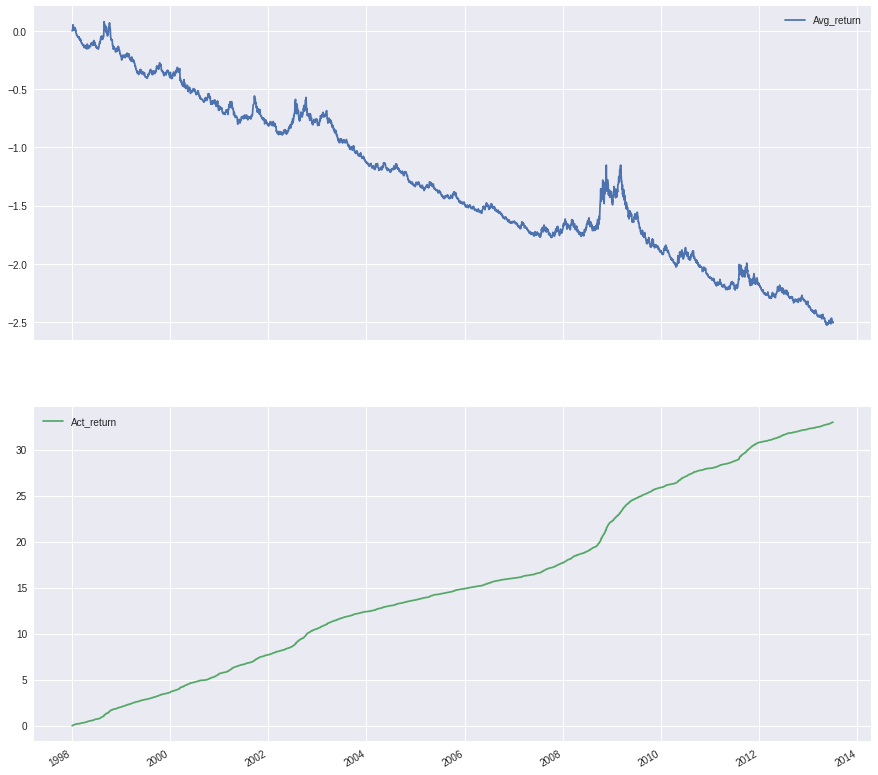

In [72]:
labeled[['Avg_return', 'Act_return']].cumsum().plot(subplots=True, figsize=(15,15))

In [ ]:
labeled['Tfclass'] = labeled['Multiclass']
test_size=600

In [ ]:
BATCH_SIZE=50
train = (inputdf[:-test_size].values,labeled.Tfclass[:-test_size].values)
val =   (inputdf[-test_size:].values,labeled.Tfclass[-test_size:].values)
NUM_TRAIN_BATCHES = int(len(train[0])/BATCH_SIZE)
NUM_VAL_BATCHES = int(len(val[1])/BATCH_SIZE)

In [87]:
len(inputdf)

3900

In [88]:
inputdf.head()

,C_2_H_aa,C_2_H_aapl,C_2_H_abc,C_2_H_abt,C_2_H_ace,C_2_H_act,C_2_H_adbe,C_2_H_adi,C_2_H_adm,C_2_H_adp,...,Vol_x,Vol_xel,Vol_xl,Vol_xlnx,Vol_xom,Vol_xray,Vol_xrx,Vol_yhoo,Vol_yum,Vol_zion
1998-01-02,0.670259,1.019696,0.296978,1.031419,0.029617,-0.347198,0.457108,0.733753,0.133289,-1.288187,...,-0.882840,-1.039835,-0.676802,1.391497,-1.045626,-1.147952,-0.817355,-0.368713,-0.678763,-0.724482
1998-01-05,0.462520,-0.984079,-0.103694,0.208524,0.200087,0.748953,0.140341,-0.610160,-0.073189,0.786681,...,-0.899201,-0.706551,-0.621025,1.019607,-0.615370,-0.556684,-0.757660,0.064841,0.980283,-0.735275
1998-01-06,-0.088471,-3.590776,-0.684038,-0.458034,0.826198,-0.839167,-0.288677,-0.793247,-0.337094,0.803780,...,-0.796421,-1.025938,-0.634169,0.020195,-0.527923,-1.131583,-0.629732,0.150071,1.697887,-0.683202
1998-01-07,1.002099,-4.732173,0.921365,1.031419,-0.221831,-0.297508,0.080277,-1.239360,0.999108,-0.148371,...,-0.787356,-0.910382,-0.616242,1.023705,-0.134130,-0.329006,-0.504232,-0.463651,0.515268,-0.635858
1998-01-08,-2.074267,-0.790227,0.602449,0.474420,0.197524,0.886626,0.327069,0.604855,-1.302776,0.364316,...,-0.857893,-0.867660,-0.655003,0.645285,-0.907375,-1.066107,-0.560549,-0.157777,0.235907,-0.605092


In [ ]:
num_features = len(inputdf.columns)
num_classes = labeled.Tfclass.nunique()

In [ ]:
RNN_HIDDEN_SIZE=128
FIRST_LAYER_SIZE=1024
SECOND_LAYER_SIZE=256
NUM_LAYERS=3
NUM_EPOCHS=1000
lr=0.0003
NUM_TRAIN_BATCHES = int(len(train[0])/BATCH_SIZE)
NUM_VAL_BATCHES = int(len(val[0])/BATCH_SIZE)
ATTN_LENGTH=30
beta=0

In [ ]:
class RNNModel():
    def __init__(self):
        global_step = tf.train.get_or_create_global_step()
        self.input_data = tf.placeholder(dtype=tf.float32, shape=[BATCH_SIZE, num_features])
        self.target_data = tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE])
        self.dropout_prob = tf.placeholder(dtype=tf.float32, shape=[])

        def makeGRUCells():
            cells = []
            global NUM_LAYERS
            NUM_LAYERS = NUM_LAYERS or 2
            for _ in range(NUM_LAYERS):
                base_cell = tf.nn.rnn_cell.GRUCell(num_units=RNN_HIDDEN_SIZE)
                attn_cell = tf.contrib.rnn.AttentionCellWrapper(cell=base_cell, attn_length=ATTN_LENGTH,
                                                                state_is_tuple=False)
                cells.append(attn_cell)
            layered_cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
            return layered_cell

        self.gru_cell = makeGRUCells()
        self.zero_state = self.gru_cell.zero_state(1, tf.float32)

        self.start_state = tf.placeholder(dtype=tf.float32, shape=[1, self.gru_cell.state_size])

        with tf.variable_scope("ff", initializer=xavier_initializer(uniform=False)):
            dropped_input = tf.nn.dropout(self.input_data, keep_prob=self.dropout_prob)

        split_inputs = tf.reshape(dropped_input, shape=[1, BATCH_SIZE, num_features],
                                  name="reshape_l1")  # Each item in the batch is a time step, iterate through them
        split_inputs = tf.unstack(split_inputs, axis=1, name="unpack_l1")
        states = []
        outputs = []
        with tf.variable_scope("rnn", initializer=xavier_initializer(uniform=False)) as scope:
            state = self.start_state
            for i, inp in enumerate(split_inputs):
                if i > 0:
                    scope.reuse_variables()

                output, state = self.gru_cell(inp, state)
                states.append(state)
                outputs.append(output)
        self.end_state = states[-1]
        outputs = tf.stack(outputs, axis=1)  # Pack them back into a single tensor
        outputs = tf.reshape(outputs, shape=[BATCH_SIZE, RNN_HIDDEN_SIZE])
        self.logits = tf.contrib.layers.fully_connected(
            num_outputs=num_classes,
            inputs=outputs,
            activation_fn=None
        )

        with tf.variable_scope("loss"):
            self.penalties = tf.reduce_sum([beta * tf.nn.l2_loss(var) for var in tf.trainable_variables()])

            self.losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.target_data)
            self.loss = tf.reduce_sum(self.losses + beta * self.penalties)
            

        with tf.name_scope("train_step"):
            opt = tf.train.AdamOptimizer(lr)
            gvs = opt.compute_gradients(self.loss)
            self.train_op = opt.apply_gradients(gvs, global_step=global_step)

        with tf.name_scope("predictions"):
            probs = tf.nn.softmax(self.logits)
            self.predictions = tf.argmax(probs, 1)
            correct_pred = tf.cast(tf.equal(self.predictions, tf.cast(self.target_data, tf.int64)), tf.float64)
            self.accuracy = tf.reduce_mean(correct_pred)
        
        #Create a summary for cost and accuracy
        tf.summary.scalar("loss", self.loss)
        tf.summary.scalar("accuracy", self.accuracy)
        
        # merge all summaries into a single "operation" which we can execute in a session 
        self.summary_op = tf.summary.merge_all()
        
        

In [ ]:
def get_batches(input, target, num_batches, train=False):
  x_batch = np.empty(shape=[num_batches, BATCH_SIZE, num_features])
  y_batch = np.empty(shape=[num_batches, BATCH_SIZE])
  
  for batch in range(0, num_batches):
    start = batch*BATCH_SIZE
    end = start + BATCH_SIZE
    x_batch[batch,:] = input[start:end]
    y_batch[batch,:] = target[start:end]
   
  if train:
    index = range(num_batches)
    np.random.shuffle(index)
    x_batch = x_batch[index]
    y_batch=  y_batch[index]
  
  for batch in range(0, num_batches):
    yield x_batch[batch], y_batch[batch]

In [ ]:
logs_path_train = './logs_train'
logs_path_test = './logs_test'

In [94]:
with tf.Graph().as_default():
    model = RNNModel()
    with tf.Session() as sess:
        init = tf.initialize_all_variables()
        sess.run([init])
        writer_train = tf.summary.FileWriter(logs_path_train, graph=tf.get_default_graph())
        writer_test = tf.summary.FileWriter(logs_path_test, graph=tf.get_default_graph())
        loss = 0
        
        for e in range(NUM_EPOCHS):
            state = sess.run(model.zero_state)
            epoch_loss =0
            i = 0
            for x_batch, y_batch in get_batches(train[0], train[1], num_batches=NUM_TRAIN_BATCHES, train=True):
                feed = {
                    model.input_data:x_batch,
                    model.target_data:y_batch,
                    model.dropout_prob:0.5,
                    model.start_state:state
                            }
                _,loss,acc,state,summary_train = sess.run(
                    [
                        model.train_op,
                        model.loss,
                        model.accuracy,
                        model.end_state,
                        model.summary_op
                    ]
                    ,feed_dict=feed
                )
                epoch_loss+=loss
                i += 1
                writer_train.add_summary(summary_train, e * NUM_TRAIN_BATCHES + i)
            if e%10 == 0:
              print('step - {0} loss - {1} acc - {2}'.format((e),epoch_loss,acc))
        final_preds =np.array([])
        j = 0
        for x_batch, y_batch in get_batches(val[0], val[1], num_batches=NUM_VAL_BATCHES ,train=False):
                feed = {
                    model.input_data:x_batch,
                    model.target_data:y_batch,
                    model.dropout_prob:1,
                    model.start_state:state
                            }
                acc,preds,state,summary_test = sess.run(
                    [
                        model.accuracy,
                        model.predictions,
                        model.end_state,
                        model.summary_op
                    ]
                    ,feed_dict=feed
                )
                writer_test.add_summary(summary_test, j)
                j += 1
                print(acc)
                assert len(preds) == BATCH_SIZE
                final_preds = np.concatenate((final_preds,preds),axis=0)

step - 0 loss - 4146.78987503 acc - 0.38
step - 10 loss - 3447.67262268 acc - 0.52
step - 20 loss - 3041.40769577 acc - 0.52
step - 30 loss - 2629.52302551 acc - 0.6
step - 40 loss - 2248.55622101 acc - 0.74
step - 50 loss - 1948.10987854 acc - 0.86
step - 60 loss - 1657.5615797 acc - 0.8
step - 70 loss - 1509.08345699 acc - 0.84
step - 80 loss - 1336.69574451 acc - 0.84
step - 90 loss - 1285.51586819 acc - 0.9
step - 100 loss - 1251.48464775 acc - 0.92
step - 110 loss - 1195.00487423 acc - 0.84
step - 120 loss - 1039.51376486 acc - 0.86
step - 130 loss - 939.698805332 acc - 0.92
step - 140 loss - 968.644631863 acc - 0.9
step - 150 loss - 954.128927708 acc - 0.98
step - 160 loss - 842.452485323 acc - 0.82
step - 170 loss - 838.371692896 acc - 0.9
step - 180 loss - 744.900806189 acc - 0.9
step - 190 loss - 823.055395126 acc - 0.96
step - 200 loss - 672.106319308 acc - 0.9
step - 210 loss - 815.510086298 acc - 0.9
step - 220 loss - 625.853144407 acc - 0.94
step - 230 loss - 739.819685936

In [107]:
!ls -l ./logs_train 
!ls -l ./logs_test 
#!ls -l ./logs_test 

total 86512
-rw-r--r-- 1 root root 42245597 Mar 31 15:59 events.out.tfevents.1522511720.576cd7c213be
-rw-r--r-- 1 root root 46340587 Mar 31 22:23 events.out.tfevents.1522512456.576cd7c213be
total 82432
-rw-r--r-- 1 root root 42201227 Mar 31 15:55 events.out.tfevents.1522511727.576cd7c213be
-rw-r--r-- 1 root root 42203247 Mar 31 22:23 events.out.tfevents.1522512465.576cd7c213be


In [ ]:
results = labeled[-test_size:].copy()
results['nn_pred_multiclass'] = final_preds
results['nn_pred_class'] = list(map(lambda x : -1 if x == 0 else 0 if x == 1 else 1, final_preds))
results['nn_pred_act_return'] = results['nn_pred_class'] * results['Avg_return']

             precision    recall  f1-score   support

         -1       0.39      0.30      0.34       213
          0       0.34      0.49      0.40       190
          1       0.35      0.29      0.32       197

avg / total       0.36      0.36      0.35       600

[[64 88 61]
 [52 93 45]
 [49 90 58]]
Normalized confusion matrix


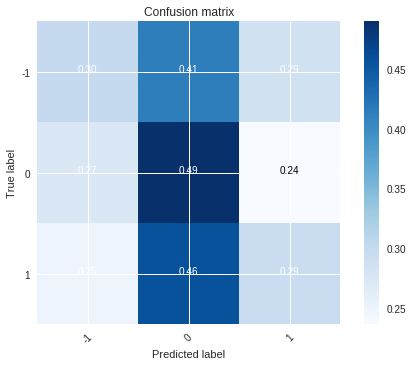

In [103]:
#cm = confusion_matrix(results['Multiclass'], results['nn_pred_multiclass'])
#print cm
#plot_confusion_matrix(cm, [i for i in range(3)], figsize)
print(classification_report(results['Class'], results['nn_pred_class']))
cm2 = confusion_matrix(results['Class'],results['nn_pred_class'])
print cm2
plot_confusion_matrix(cm2, [-1, 0, 1], figsize)

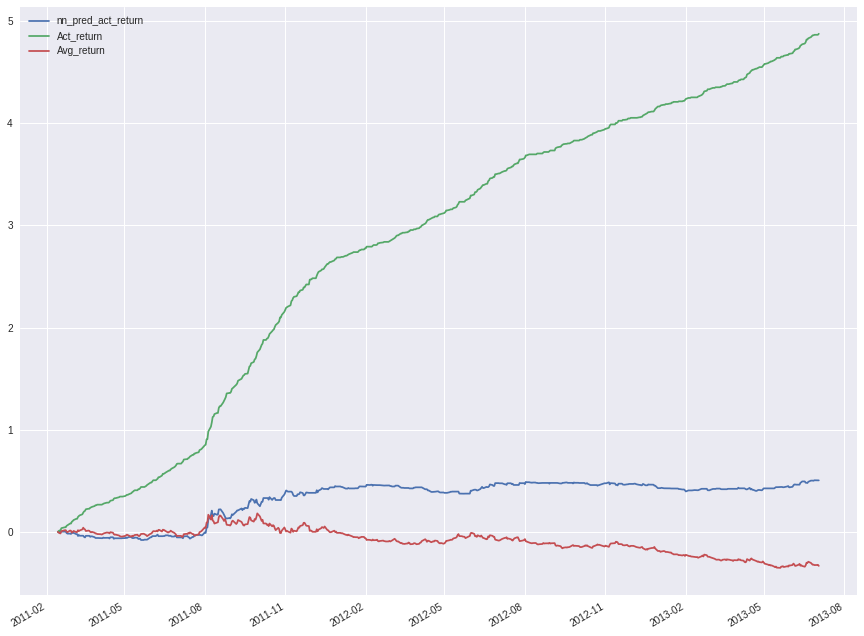

In [104]:
res = (results[['nn_pred_act_return', 'Act_return', 'Avg_return']]).cumsum()
#res[0] = 0
res.plot(figsize=(15,12))

In [ ]:
from google.colab import files
files.download('./logs_train/events.out.tfevents.1522511720.576cd7c213be')
files.download('./logs_train/events.out.tfevents.1522512456.576cd7c213be')
files.download('./logs_test/events.out.tfevents.1522511727.576cd7c213be')
files.download('./logs_test/events.out.tfevents.1522512465.576cd7c213be')